<a href="https://colab.research.google.com/github/owenparsons3/RL-team/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

This code is adapted from a YouTube Tutorial by brthor.
(Source: https://www.youtube.com/watch?v=NP8pXZdU-5U&t=0s retrieved in April 2024.)


Human level control through deep reinforcement learning (paper): DQN algorithm introduced by deepmind

Replace the Q table in Q-learning with a deep neural network to estimate the Q-function. Q-function takes a state and returns the Q-value for each state action pair.

#Set up

In [9]:
import torch
from torch import nn
import numpy as np
import gym
from collections import deque
import itertools
import random

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Hyperparameters
GAMMA = TD target discount rate

BATCH_SIZE = number of samples from replay buffer when computing gradients

BUFFER = maximum number of transitions to store before updating old transitions

REPLAY_MIN = minimum number of transition in the replay buffer before starting training

EPS_START = start value for epsilon

EPS_END = end value for epsilon EPS_START and EPS_END

EPS_DECAY = number of steps between

TARGET_UPDATE_FREQUENCY = frequency for updating the target parameters

LR = learning rate

In [10]:
#Hyperparameters
GAMMA = 0.99
BATCH_SIZE = 32
BUFFER = 50000
REPLAY_MIN = 1000
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 10000
TARGET_UPDATE_FREQUENCY = 1000
LR = 5e-4

#Environment


Create a network class, which you do in PyTorch by creting a class that inherits from nn.Module. Initialise the class by calling the superclass.

**Network structure:**

**Input Layer** - the number of inputs to the network (input_features) calculate by doing a product of the environment space.

Then a standard 2 layer sequential network with 64 hidden units separated by a Tanh non-linearity.

**Linear Layer**

**Tanh Layer**

The number of outputs for the network is equal to the number of actions available to the agaent.

**Linear Layer**

In [11]:
class Network(nn.Module):
  def __init__(self, env):
    super().__init__()

    #for 1D spaces the product is not necessary e.g. CartPole, but it will be important for atari games which ar 3D for the images
    input_features = int(np.prod(env.observation_space.shape))

    self.net = nn.Sequential(
        nn.Linear(input_features, 64),
        nn.Tanh(),
        nn.Linear(64, env.action_space.n)
    )

  #The forward function is required to run any PyTorch network
  def forward(self, x):
    return self.net(x)

  def act(self, obs):
    obs_t = torch.as_tensor(obs, dtype=torch.float32)
    q_values = self(obs_t.unsqueeze(0)) #unsqueeze 0 to create a fake batch dimension because pytorch operations expect a batched dimension, we are not using a batched env
    max_q_index = torch.argmax(q_values, dim=1)[0]
    action = max_q_index.detach().item() #turn pytorch tensor into an integer using detach method

    return action

Create a replay buffer that has a max length of BUFFER.

Also create a reward buffer that stores the rewards for an episode to track training performance.

In [12]:
env = gym.make("CartPole-v1")

replay_buffer = deque(maxlen=BUFFER)
reward_buffer = deque([0.0], maxlen=100)

#there may be better ways to do this using gym and "monitor"
episode_reward = 0.0

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


#Create neural networks

In [13]:
online_network = Network(env)
target_network = Network(env)

#optimise using the adam optimiser
optimiser = torch.optim.Adam(online_network.parameters(), lr=LR)

#set the target network parameters equal to the online network parameters (because they were initialised separately), this is also part of the algorithm in the paper
target_network.load_state_dict(online_network.state_dict())



<All keys matched successfully>

##Initialise replay buffer

In [14]:
#reset the environment to get the first observation
obs = env.reset()

#get the first set of actions and observations before training using replay_min
for _ in range(REPLAY_MIN):

  #take an action
  action = env.action_space.sample()

  #take a step in the environment based on the action and get teh new observations, reward and whether the episode is over
  #store this information in the replay buffer
  #set observation to the new observation
  new_obs, reward, done, info = env.step(action)
  transition = (obs, action, reward, done, new_obs)
  replay_buffer.append(transition)
  obs = new_obs

  #reset the environment if the episode is over
  if done:
    obs = env.reset()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


#Training

In [1]:
obs = env.reset()

for step in itertools.count():

  #Epsilon greedy policy to facilitate exploration
  epsilon = np.interp(step, [0, EPS_DECAY], [EPS_START, EPS_END])

  sample = random.random()

  if sample <= epsilon:
    action = env.action_space.sample()
  else:
    action = online_network.act(obs)

  #take a step in the environment based on the action and get teh new observations, reward and whether the episode is over
  #store this information in the replay buffer
  #set observation to the new observation and add set reward to episode reward
  new_obs, reward, done, info = env.step(action)
  transition = (obs, action, reward, done, new_obs)
  replay_buffer.append(transition)
  obs = new_obs

  episode_reward += reward

  #reset the environment if the episode is over
  if done:
    obs = env.reset()

    reward_buffer.append(episode_reward)
    episode_reward = 0.0


  #Render
  ########
  # if len(reward_buffer) >= 100:
  #   if np.mean(reward_buffer) >= 195:
  #     while True:
  #       action = online_network.act(obs)
  #       obs, _, done, _ = env.step(action)
  #       env.render()
  #       if done:
  #         env.reset()

  #Start gradient steps
  #####################
  #sample BATCH_SIZE number of samples from the replay buffer
  transitions = random.sample(replay_buffer, BATCH_SIZE)

  #separate transition tuple and use it to create lists for the batch and then convert to np (faster for converting to pytorch tensor)
  obses = np.asarray([t[0] for t in transitions])
  actions = np.asarray([t[1] for t in transitions])
  rewards = np.asarray([t[2] for t in transitions])
  dones = np.asarray([t[3] for t in transitions])
  new_obses = np.asarray([t[4] for t in transitions])

  obses_t = torch.as_tensor(obses, dtype=torch.float32)
  actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1) #unsqeeze -1 adds dimension at the end
  rewards_t = torch.as_tensor(rewards, dtype=torch.float32).unsqueeze(-1)
  dones_t = torch.as_tensor(dones, dtype=torch.float32).unsqueeze(-1)
  new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32)


  #Compute Targets
  ################
  target_q_values = target_network(new_obses_t)

  #we want the highest q-value per observation
  max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]

  #if the episode is over (dones_t = 1) then we zero out the rest of the function only leaving the reward
  targets = rewards_t + GAMMA * (1 - dones_t) * max_target_q_values

  #Compute Loss
  #############
  q_values = online_network(obses_t)

  #getting q_value for the action taken
  action_q_values = torch.gather(input=q_values, dim=1, index=actions_t)

  #huber loss function (smooth_l1_loss in pytorch)
  loss = nn.functional.smooth_l1_loss(action_q_values, targets)

  #Gradient Descent
  ##################

  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

  #update target network parameters
  if step % TARGET_UPDATE_FREQUENCY == 0:
    target_network.load_state_dict(online_network.state_dict())

  #Logging
  if step % 1000 == 0:
    print()
    print('Step', step)
    print('Avg reward', np.mean(reward_buffer))




NameError: name 'env' is not defined

In [28]:
!apt-get install x11-utils
!pip install pyglet
!apt-get install -y xvfb python3-opengl
!pip install gym pyvirtualdisplay


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-utils is already the newest version (7.7+5build2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libglu1-mesa libxfont2 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  libgle3 python3-numpy
The following NEW packages will be installed:
  freeglut3 libglu1-mesa libxfont2 python3-opengl x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 10 newly installed, 0 to remove and 45 not upgraded.
Need to get 8,551 kB of archives.
After this operation, 19.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6 [74.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/m

KeyboardInterrupt: 

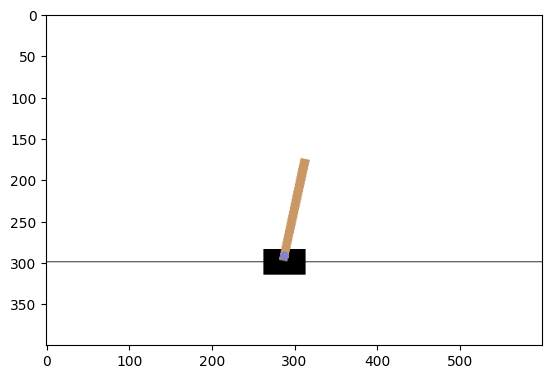

In [29]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()